# Setup and Mount Google Drive

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from torchsummary import summary


from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle

from sklearn.metrics import confusion_matrix
import seaborn as sn

plt.style.use('ggplot')

import os
import subprocess
import pandas as pd


def download_data():
    if not os.path.exists('./efigi-1.6/png/'):
        subprocess.run([
            'wget',
            'https://www.astromatic.net/download/efigi/efigi_png_gri-1.6.tgz',
            '-O data.tgz'
        ])
        subprocess.run([
            'tar',
            '-xzvf data.tgz'
        ])
        os.remove('./ data.tgz')
        print('efigi_png downloaded!')

    if not os.path.exists('./efigi-1.6/EFIGI_attributes.txt'):
        subprocess.call([
            'wget',
            'https://www.astromatic.net/download/efigi/efigi_tables-1.6.2.tgz',
            '-O data.tgz'
        ])
        subprocess.call([
            'tar',
            '-xzvf data.tgz'
        ])
        os.remove('./ data.tgz')

        path = './efigi-1.6/'
        for f in os.listdir('./efigi-1.6/'):
            if f != 'EFIGI_attributes.txt' and f.endswith('.txt'):
                os.remove(f'{path}/{f}')

        print('efigi_tables downloaded!')


def prepare_data(path):
    with open(path, 'rb') as f:
        line = None
        for i in range(82):
            line = f.readline()
        headers = str(line).split()[1:]

    df = pd.read_csv(path, comment='#', header=None)
    s = df[0].str.split()
    df = pd.DataFrame(s.values.tolist(), index=s.index, columns=headers)
    df['T'] = df['T'].astype(int)

    class_names = ['Ellipticals', 'Lenticulars', 'Spirals', 'Irregulars']
    class_types = [[-4, -5, -6], [-3, -2, -1], list(range(0, 10)), [90, 10, 11]]

    data = pd.DataFrame()
    data['name'] = df['PGCname']
    for i, (c_name, c_type) in enumerate(zip(class_names, class_types)):
        mask = df['T'].isin(c_type)
        data.loc[mask, 'class_name'] = c_name
        data.loc[mask, 'class_label'] = i

    data['class_label'] = data['class_label'].astype(int)
    return data


    # run this cell to download and prepare data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()


#lenticulars,spirals, irregulars and ellipticals

elliptical_ds = []
spiral_ds = []
lenticulars_ds = []
irregular_ds = []
name = df['name']
class_name = df['class_name']

for i in range(len(name)):
    if class_name[i].lower() == "spirals":
        spiral_ds.append(name[i])
    elif class_name[i].lower() == "ellipticals":
        elliptical_ds.append(name[i])
    elif class_name[i].lower() == "lenticulars":
        lenticulars_ds.append(name[i])
    else:
        irregular_ds.append(name[i])

print("irregular_ds: "+str(len(irregular_ds)))
print("elliptical_ds: "+str(len(elliptical_ds)))
print("spiral_ds: "+str(len(spiral_ds)))
print("lenticulars_ds: "+str(len(lenticulars_ds)))



def get_image_from_folder(folder_path,ID):
    image_list = []
    allowed_extensions = ['.png']

    if not os.path.isdir(folder_path):
        return "Error: Invalid folder path."

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and os.path.splitext(filename)[1].lower() in allowed_extensions and os.path.splittext(filename[0])==ID:
            image_list.append(file_path)
    return image_list




import os
import shutil

class_labels = ["Spirals", "Ellipticals", "Lenticulars", "Irregulars"]

# Makes a main folder for the datasets to be stored
main_path = "./GalaxyImages"
ds_pic_path = "./efigi-1.6/png"

os.makedirs(main_path, exist_ok=True)
print("Directory 'GalaxyImages' created successfully")

for i in range(len(class_labels)):
    print("Loop " + str(i) + " done")

    target_destination_dir = os.path.join(main_path, class_labels[i])
    os.makedirs(target_destination_dir, exist_ok=True)

    dataset = []
    if i == 0:
        dataset = spiral_ds
    elif i == 1:
        dataset = elliptical_ds
    elif i == 2:
        dataset = lenticulars_ds
    else:
        dataset = irregular_ds

    for j in dataset:
        target_source = os.path.join(ds_pic_path, j + ".png")
        target_destination = os.path.join(target_destination_dir, j + ".png")

        if os.path.exists(target_source):
            shutil.copyfile(target_source, target_destination)
        else:
            print(f"Warning: Source file {target_source} does not exist.")


#debug

print("expected spiral: 3315,  Obtained images: " + str(len(os.listdir(os.path.join(main_path, class_labels[0])))))
print("expected elliptical: 289,  Obtained images: " + str(len(os.listdir(os.path.join(main_path, class_labels[1])))))
print("expected lenticulars: 537,  Obtained images: " + str(len(os.listdir(os.path.join(main_path, class_labels[2])))))
print("expected Irregulars: 317,  Obtained images: " + str(len(os.listdir(os.path.join(main_path, class_labels[3])))))

efigi_png downloaded!
efigi_tables downloaded!
irregular_ds: 317
elliptical_ds: 289
spiral_ds: 3315
lenticulars_ds: 537
Directory 'GalaxyImages' created successfully
Loop 0 done
Loop 1 done
Loop 2 done
Loop 3 done
expected spiral: 3315,  Obtained images: 3315
expected elliptical: 289,  Obtained images: 289
expected lenticulars: 537,  Obtained images: 537
expected Irregulars: 317,  Obtained images: 317


In [2]:
from google.colab import drive # this imports drive from google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NOTES


- Look at confusion matrix, the classes are imbalanced causing this issue

# Import Required Libraries

In [3]:
# import all the required libraries, use tensor flow for model - watch some video about tensorflow functions

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display
from PIL import Image

# Set Parameters and Data Preparation


In [4]:

img_width, img_height = 224, 224  # set the images to all same size
batch_size = 32 #dataset is split into batches of 32
epochs = 5 # how many cycles of training


path_to_training_data = '/content/drive/MyDrive/Cutout Files' # dataset


#data augmentation
train_datagen = ImageDataGenerator( #when is this used?
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)


train_generator = train_datagen.flow_from_directory(
    path_to_training_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    path_to_training_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

Found 3190 images belonging to 2 classes.
Found 796 images belonging to 2 classes.


# Model

In [ ]:
def build_model():
  # model from tensorflow
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))


    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Model Training Before Transfer Learning

In [ ]:
history = model.fit(  # this trains the neural net with dataset
    train_generator,
    epochs=epochs,
    validation_data=validation_generator)

initial_test_loss, initial_test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Test Accuracy Before Fine-tuning: {initial_test_acc*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 854s 8s/step - accuracy: 0.7580 - loss: 0.5252 - val_accuracy: 0.7450 - val_loss: 0.4716
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.7819 - loss: 0.4383 - val_accuracy: 0.7789 - val_loss: 0.4225
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.7858 - loss: 0.4238 - val_accuracy: 0.7977 - val_loss: 0.4188
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.7973 - loss: 0.4156 - val_accuracy: 0.7802 - val_loss: 0.4298
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.7949 - loss: 0.4003 - val_accuracy: 0.7927 - val_loss: 0.4208
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8052 - loss: 0.3736
Test Accuracy Before Fine-tuning: 79.04%


# Plot Accuracy and Loss Before Fine-Tuning

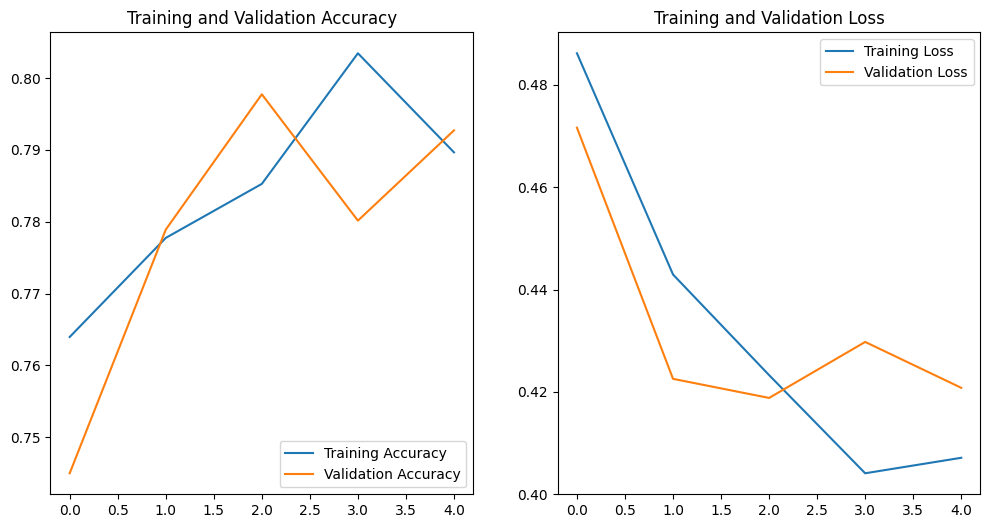

24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7996 - loss: 0.3961
Test Accuracy After Fine-tuning: 78.65%


In [ ]:
def plot_acc_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_acc_loss(history)
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Test Accuracy After Fine-tuning: {test_acc*100:.2f}%")

# Fine-Tuning and Re-Training

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_generator, epochs=5, validation_data=validation_generator)


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.7440 - loss: 0.5343 - val_accuracy: 0.7864 - val_loss: 0.4190
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.7809 - loss: 0.4467 - val_accuracy: 0.7802 - val_loss: 0.4269
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.7706 - loss: 0.4510 - val_accuracy: 0.8003 - val_loss: 0.4077
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.8052 - loss: 0.3970 - val_accuracy: 0.7877 - val_loss: 0.4195
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.8195 - loss: 0.3953 - val_accuracy: 0.7877 - val_loss: 0.4207


# Plot Accuracy and Loss After Transfer Learning

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.8086 - loss: 0.3994 - val_accuracy: 0.8053 - val_loss: 0.4013
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.8026 - loss: 0.4065 - val_accuracy: 0.7839 - val_loss: 0.4223
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.7790 - loss: 0.4468 - val_accuracy: 0.8065 - val_loss: 0.3999
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.8043 - loss: 0.3915 - val_accuracy: 0.7764 - val_loss: 0.4050
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.8093 - loss: 0.3959 - val_accuracy: 0.8040 - val_loss: 0.3990


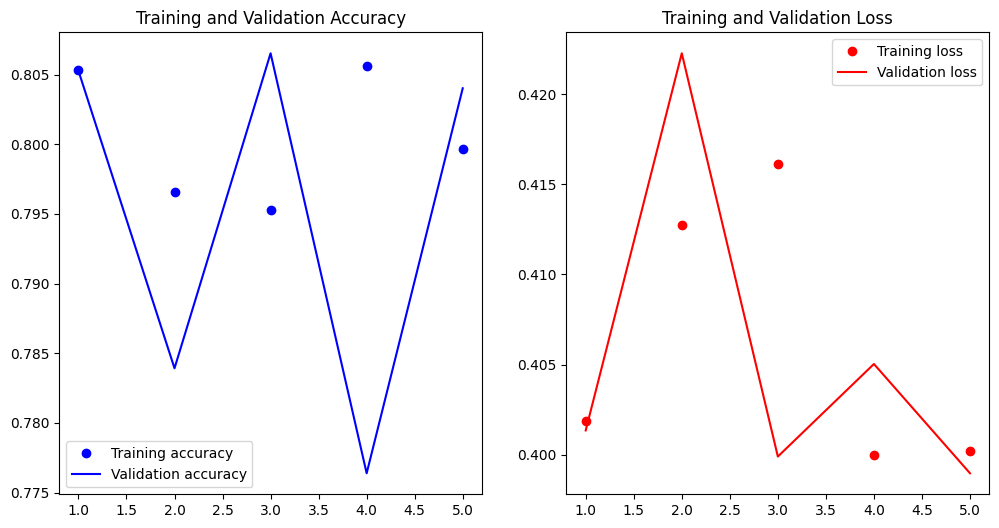

In [ ]:
fine_tune_history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)
import matplotlib.pyplot as plt

def plot_acc_loss(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


plot_acc_loss(fine_tune_history)


# Final Evaluation and Display Predictions

In [ ]:
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Test Accuracy After Fine-tuning: {test_acc*100:.2f}%")

# Display Classification Metrics and Confusion Matrix

25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step


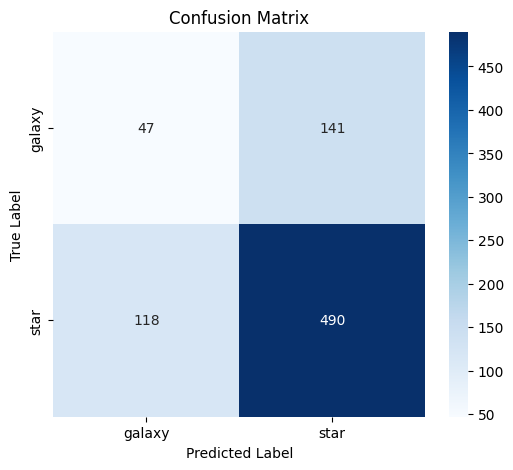

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def display_confusion_matrix(true_classes, predicted_classes, class_labels):
    """
    This function computes and displays a confusion matrix.
    """
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Get model predictions
predictions = model.predict(validation_generator)

# Convert probabilities to binary class predictions (0 or 1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Get true labels (already 0 or 1)
true_classes = validation_generator.classes.flatten()

# Define class labels (assuming binary classification)
class_labels = list(validation_generator.class_indices.keys())

# Display the confusion matrix
display_confusion_matrix(true_classes, predicted_classes, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


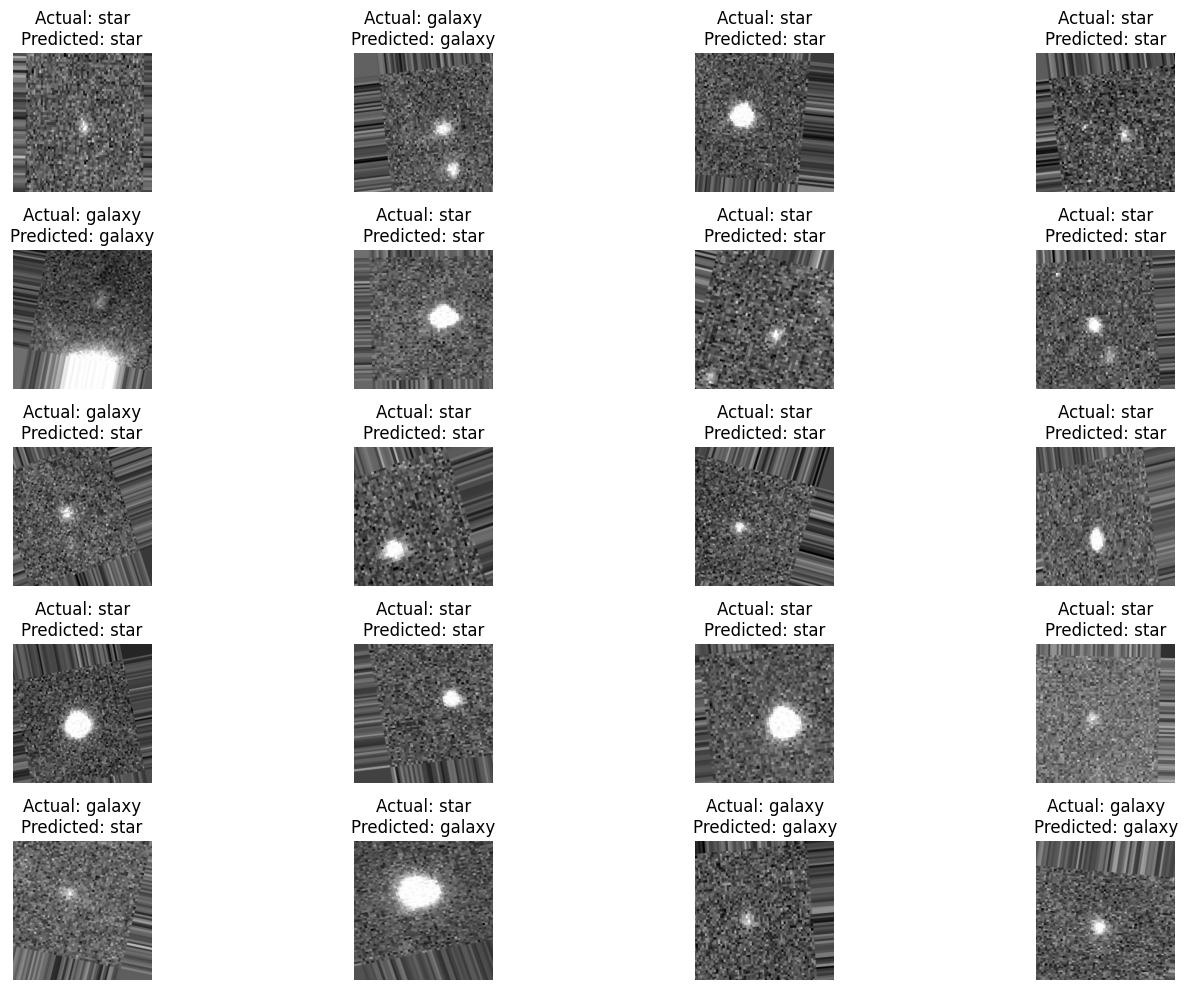

In [ ]:
def display_predictions(model, generator, num_images=20):
    """
    This function fetches a batch of images, predicts using the model,
    and displays the images with actual and predicted labels.
    """
    generator.reset()  # Resetting the generator to avoid shuffling issues
    x, y_true = next(generator)
    predictions = model.predict(x)

    # Convert probabilities to binary predictions (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = y_true.flatten().astype(int)

    # Get class labels from generator
    class_labels = list(generator.class_indices.keys())

    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(x))):  # Ensure we don't exceed batch size
        plt.subplot(5, 4, i + 1)  # Adjust subplot grid for the number of images
        plt.imshow(x[i])
        plt.title(f'Actual: {class_labels[true_classes[i]]}\nPredicted: {class_labels[predicted_classes[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_predictions(model, validation_generator, num_images=20)